In [42]:
#export HDF5_USE_FILE_LOCKING=FALSE
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
from obspy import read
from scipy import signal
import glob

In [2]:
from xdas.io.febus import read as read_das
from xdas.io.febus import correct_gps_time

In [18]:
path1 = "/Volumes/DISKENOIR/Correlograms/Cross-correlation/SR_FEBUS_STROMBOLI_2022-09-18_17-35-44_UTC/"
path2 = "/Volumes/DISKENOIR/fichiers-nc/"

### Functions

In [5]:
# from Alister
def fk_analysis(x, dt, ds, dbscale=True, onesided=True):                        
    """Compute the FK analysis of x with expected dims (time, offset)"""        
    fk = np.fft.fft2(x)                                                         
    f = np.fft.fftshift(np.fft.fftfreq(fk.shape[0], dt))                        
    k = np.fft.fftshift(np.fft.fftfreq(fk.shape[1], ds))                        
    fk = np.fft.fftshift(fk)                                                    
    if onesided:                                                                
        mask = (f >= 0)                                                         
        fk = fk[mask]                                                           
        f = f[mask]                                                             
    if dbscale==True:                                                                 
        fk = 20 * np.log(np.abs(fk)) 
    else:
        fk = abs(fk)                                     
    return f, k, fk  

def filter_bandpass(trace, lowcut, highcut, fs, order=2):
	nyq = 0.5 * fs
	low = lowcut/nyq
	high = highcut/nyq
	#order = 2
	b,a = signal.butter(order, [low, high], 'bandpass', analog=False)
	trace_filtered = signal.filtfilt(b, a, trace, axis=0)
	return trace_filtered

def normalize(trace):	# normalize trace
		return trace / max(trace)

def stack(folders):
	stacked = np.zeros(len(read(folders[0])[0]))
	for file in folders:
		a = read(file)
		stacked = stacked + a[0].data
	return stacked

# gather the tf-pws
def collect_tfpws(folder,x1,x2):
	files = glob.glob(f'{folder}/Correlogram_{str(x1)}_{str(x2)}_pcc/ts_pws_tspws_pcc.sac') # only consider the phase
	#files = glob.glob(f'{folder}/Correlogram_{str(x1)}_{str(x2)}_pcc/ts_pws_tspws_pcc_half_zeromid.sac') # only consider the phase
	#print(files)
	try:
		stacked = read(files[0])[0].data
	except:
		files = glob.glob(f'{folder}/Correlogram_{str(x1)}_{str(x2-1)}_pcc/ts_pws_tspws_pcc_half_zeromid.sac') # try except works when using half stack
		stacked = read(files[0])[0].data
	return stacked


### Correlogram gather plot

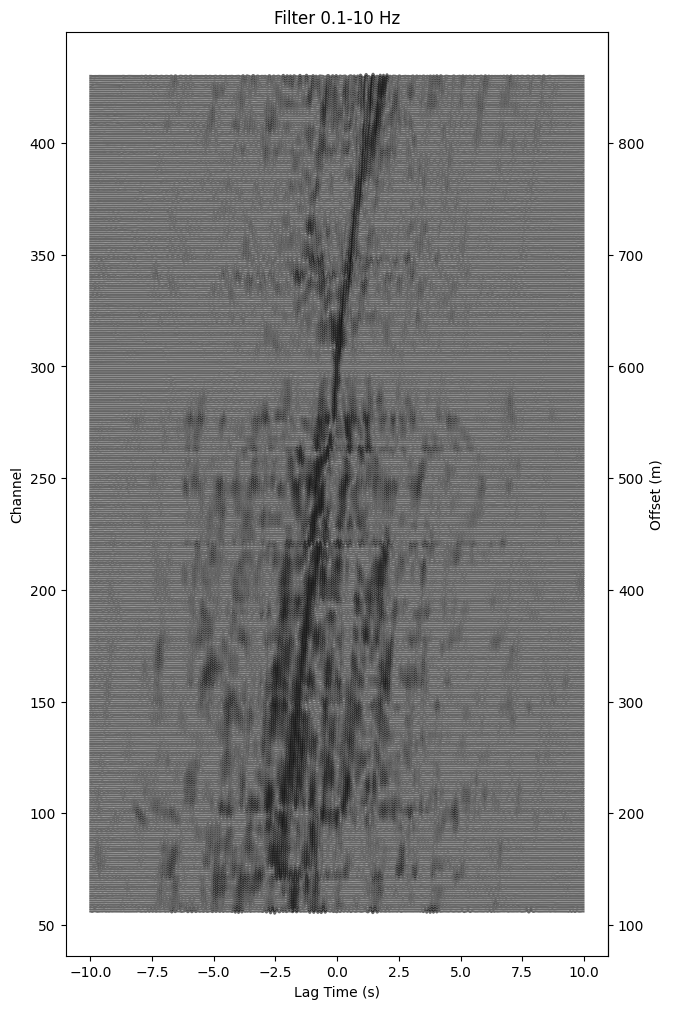

'\n# for plotting cross-correlogram gather without certain channels\n#remove = [50,51,52,53,54,55,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250]\nremove= []\nmask = np.isin(ranges,remove)\nmask = [not mask[i] for i in range(len(mask))]\ncc_cut = cc[boundary1:boundary2,ranges[mask]-50]\n'

In [63]:
folder = path1
# to plot half stack, change: collect_tfpws, file, and plt.plot, and cc_fk

# parameters
start_channel = 300
nb_channel = 150  # define the number of channel needed to be gathered, depend on start_position. not used when start_position = 'mid_all'
	       			# because automatically uses all channels
window = 300
start_position = 'mid_all'
dt = 0.02  # sampling rate (s)
dx = 2  # distance between the channels (m)
fs = 1 / dt # sampling rate (1/s)

x1, x2 = start_channel, 56
file = f'{folder}Correlogram_{str(x1)}_{str(x2)}_pcc/ts_pws_tspws_pcc.sac'
#file = f'{folder}/Correlogram_{str(x1)}_{str(x2)}_pcc/ts_pws_tspws_pcc_half_zeromid.sac' 
a = read(file)[0].data

cut1 = 56   # start and end of the channel to be plotted
cut2 = 430
if start_position == 'mid':
	cc = np.zeros((a.shape[0],2*nb_channel+1))
elif start_position == 'mid_all':
	cc = np.zeros((a.shape[0],cut2-cut1+1))	
else:
	cc = np.zeros((a.shape[0],nb_channel+1))

t = np.arange(0,a.shape[0]*dt,dt)

if start_position == 'mid':
	ranges = np.arange(start_channel-nb_channel,start_channel+nb_channel+1,1)
elif start_position == 'mid_all':
	ranges = np.arange(cut1,cut2+1,1)
elif start_position == 'early':
	ranges = np.arange(start_channel,start_channel+nb_channel+1,1)
elif start_position == 'end':
	ranges = np.arange(start_channel,start_channel-nb_channel-1,-1)

filtering = True
lowcut = 0.1  # filter if needed
highcut = 10
j = 0

# collect all tf-pws of each channel pair and store it in an array
for i_channel in ranges:
	x1,x2 = start_channel, i_channel
	#folders = glob.glob(f'{folder}/Correlogram_{str(x1)}_{str(x2)}_{mode}/*.sac')
	#stacked = stack(folders)
	stacked = collect_tfpws(folder,x1,x2)
	if filtering :
		stacked = filter_bandpass(stacked, lowcut, highcut, fs, order=2)
	cc[:,j] = normalize(stacked)
	j = j + 1

# set time boundary
time_lim1 = -10
time_lim2 = 10
boundary1 = int(((time_lim1 + window) / (window * 2)) * cc.shape[0])
boundary2 = int(((time_lim2 + window) / (window * 2)) * cc.shape[0])
#boundary1 = int(((time_lim1) / (window)) * cc.shape[0]) # use this for the half stack
#boundary2 = int(((time_lim2) / (window)) * cc.shape[0])
t_cut = np.arange(time_lim1,time_lim2,dt)

lag = len(cc[:,0])/2 - np.where(cc[:,0]==max(cc[:,0]))[0][0]
t_cut_zeromid = np.arange(time_lim1+lag*dt,time_lim2+lag*dt,dt)
cc_cut = cc[boundary1:boundary2,:]

# functions for plotting secondary axis (offset) in plot
def get_channel(x):
	return x

def get_offset(x):
	return dx * (x)

scaler = 1
remove= []

plt.figure(figsize=(7,12))
j = 0
for i in ranges:
	if i not in remove:
		#plt.plot(t, normalize(cc[:,j]) + i*1, color='black',alpha=0.6)
		plt.plot(t_cut,cc_cut[:,j] + (i)*scaler, color='black',alpha=0.6) # use t_cut_zeromid if needed
		'''try:
			plt.plot(t_cut,normalize(cc_cut[:,j]) + (i)*scaler, color='black',alpha=0.6) 
		except:
			plt.plot(t_cut,normalize(np.append(cc_cut[:,j],0)) + (i)*scaler, color='black',alpha=0.6) 
		'''
	j = j + 1

ax = plt.gca()
y2 = ax.secondary_yaxis('right', functions=(get_offset, get_channel))
y2.set_ylabel('Offset (m)')
plt.title('Filter 0.1-10 Hz')
plt.xlabel('Lag Time (s)')
plt.ylabel('Channel')
#plt.xlim(0,5)
plt.show()


# np.savetxt("west_256_430.txt", cc_fk.T,fmt="%s")
# content = np.genfromtxt('west_256_430.txt', delimiter=',', dtype=None,encoding = 'UTF-8')

'''
# for plotting cross-correlogram gather without certain channels
#remove = [50,51,52,53,54,55,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250]
remove= []
mask = np.isin(ranges,remove)
mask = [not mask[i] for i in range(len(mask))]
cc_cut = cc[boundary1:boundary2,ranges[mask]-50]
'''


### F-K computation

dx= 2  dt= 0.02   data=  2020
Pick the strong amplitude. Left button to pick, right button to cancel last pick, middle button to stop (max=100 picks)


/var/folders/59/7kx72ydj205__qxdqtz0vm0m0000gr/T/ipykernel_66184/2348843421.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  x = plt.ginput(100)


[]


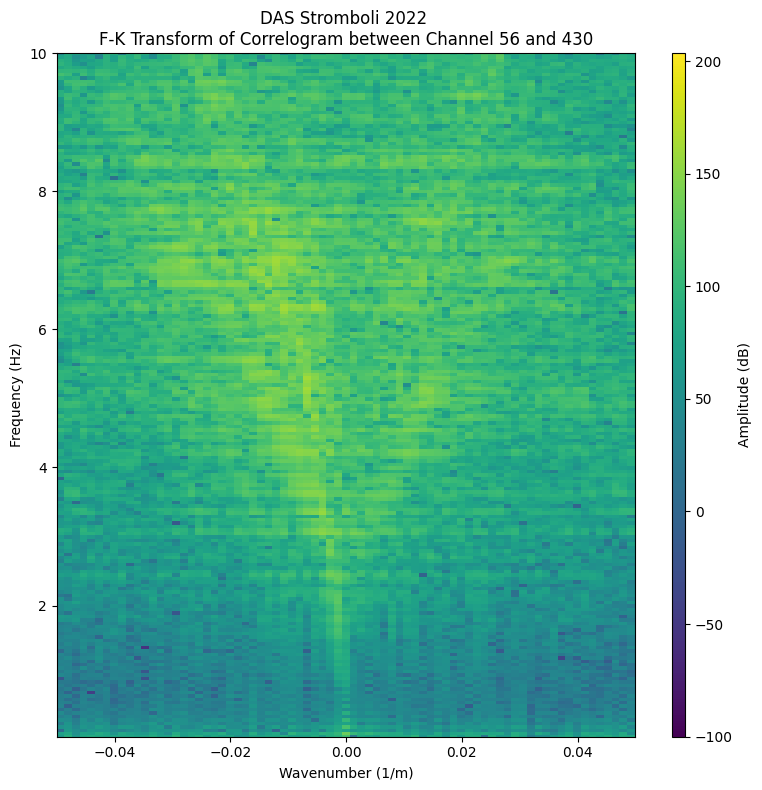

In [9]:
dx = 2
dt= 0.02
print('dx=',dx,' dt=',dt,'  data= ',str(2020))

pick = True    # change to True if pick is needed
cc_fk = cc_cut  # use 'cc' if half stack is used
#cc_fk = cc
f, k, fk = fk_analysis(cc_fk, dt, dx, dbscale=True, onesided=True)    

fig = plt.figure(figsize=(8,8))                                           
ax = plt.gca()                                                    
fkmax = np.nanmax(fk.flatten())                                             
fkmin = np.nanmin(fk.flatten())                                       
im = ax.pcolor(k,f,fk,vmin = -100,vmax=fkmax,cmap=plt.cm.viridis)
ax.set_xlabel('Wavenumber (1/m)')                                                                 
ax.set_ylabel('Frequency (Hz)')                                             
ax.set_title(f'DAS Stromboli 2022 \nF-K Transform of Correlogram between Channel {str(ranges[0])} and {str(ranges[-1])}' ) 
colorbar = plt.colorbar(im, aspect=50)
colorbar.set_label(label='Amplitude (dB)', rotation=90)
plt.tight_layout()
plt.ylim(0.1,10)
plt.xlim(-0.05,0.05)           

# pick value
if pick:
	print("Pick the strong amplitude. Left button to pick, right button to cancel last pick, middle button to stop (max=100 picks)")
	x = plt.ginput(100)
	print(x)
	k_pick = np.array([i[0] for i in x])
	f_pick = np.array([i[1] for i in x])
	plt.plot(k_pick,f_pick,'--r',lw=1)
	plt.plot(-k_pick,f_pick,'--b',lw=1)

plt.show()

### Phase velocity plotting

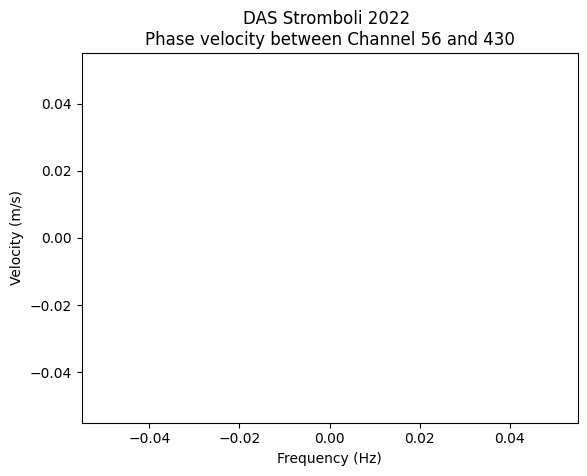

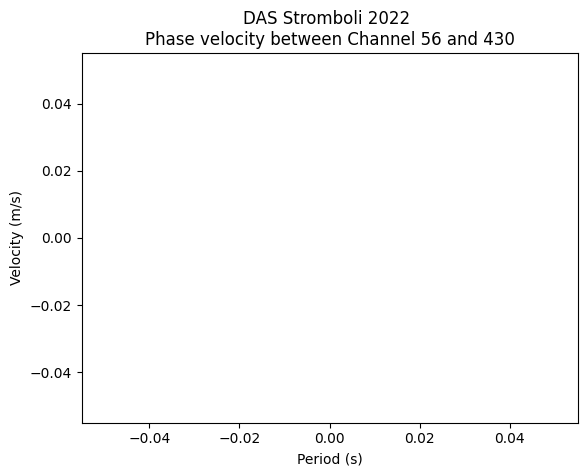

"\n# Auto-pick fk plot\n# still hard to use because of the maximum amplitude of FK plot is highly scattered (maybe smoothing is needed?)\n\nfrom scipy.ndimage import gaussian_filter\nfrom scipy.interpolate import make_interp_spline, BSpline\n#fk_int = gaussian_filter(fk, sigma=2)\n\ncut = 0\nf_peak = [] # getting the index of v based on the highest stransform value \nf_low = []\nf_high = []\n\nfor idx_k in range(fk.T.shape[0]):\n\t#if k[idx_k] < 0:\n\tprint('yes')\n\ta = np.where(fk[cut:,idx_k] == np.max(fk[cut:,idx_k]))\n\tbound = np.where((fk[cut:,idx_k] > 0.3 * np.max(fk[cut:,idx_k])) & (fk[cut:,idx_k] < np.max(fk[cut:,idx_k])))\n\tb = f[a[0][0]+cut]\n\tbound_high = f[bound[0][-1]+cut]\n\tbound_low = f[bound[0][0]+cut]\n\tf_peak.append(b)\n\tf_low.append(bound_low)\n\tf_high.append(bound_high)\n\ndef interpolate(f,v):\n\tf_int = np.linspace(f[0], f[-1], 200)\n\tinterpolate = make_interp_spline(sorted(f), v, k=3)\n\tv_int = interpolate(f_int)\n\treturn f_int, v_int\n\nk_int, f_peak =

In [10]:
v = np.array(f_pick) / np.array(k_pick)
period = 1 / np.array(f_pick)

# plotting in frequency
plt.figure()
plt.plot(f_pick,abs(v))
plt.title(f'DAS Stromboli 2022 \nPhase velocity between Channel {str(ranges[0])} and {str(ranges[-1])}' ) 
#plt.xlabel('Frequency (Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Velocity (m/s)')
plt.show()

# plotting in period
plt.figure()
plt.plot(period,abs(v))
plt.title(f'DAS Stromboli 2022 \nPhase velocity between Channel {str(ranges[0])} and {str(ranges[-1])}' ) 
#plt.xlabel('Frequency (Hz)')
plt.xlabel('Period (s)')
plt.ylabel('Velocity (m/s)')
plt.show()


'''
# Auto-pick fk plot
# still hard to use because of the maximum amplitude of FK plot is highly scattered (maybe smoothing is needed?)

from scipy.ndimage import gaussian_filter
from scipy.interpolate import make_interp_spline, BSpline
#fk_int = gaussian_filter(fk, sigma=2)

cut = 0
f_peak = [] # getting the index of v based on the highest stransform value 
f_low = []
f_high = []

for idx_k in range(fk.T.shape[0]):
	#if k[idx_k] < 0:
	print('yes')
	a = np.where(fk[cut:,idx_k] == np.max(fk[cut:,idx_k]))
	bound = np.where((fk[cut:,idx_k] > 0.3 * np.max(fk[cut:,idx_k])) & (fk[cut:,idx_k] < np.max(fk[cut:,idx_k])))
	b = f[a[0][0]+cut]
	bound_high = f[bound[0][-1]+cut]
	bound_low = f[bound[0][0]+cut]
	f_peak.append(b)
	f_low.append(bound_low)
	f_high.append(bound_high)

def interpolate(f,v):
	f_int = np.linspace(f[0], f[-1], 200)
	interpolate = make_interp_spline(sorted(f), v, k=3)
	v_int = interpolate(f_int)
	return f_int, v_int

k_int, f_peak = interpolate(k,np.array(f_peak))
k_int, f_low = interpolate(k,np.array(f_low))
k_int, f_high = interpolate(k,np.array(f_high))
'''

In [12]:
f_pick

array([], dtype=float64)

### FK plot using traces data

In [51]:
file_name = "SR_FEBUS_STROMBOLI_2022-09-18_17-35-44_UTC.nc"

In [56]:
ds = xr.open_dataset(path2 + file_name)
ds

<xarray.Dataset>
Dimensions:       (times: 180000, offsets: 3250, channels: 3250)
Coordinates:
  * times         (times) datetime64[ns] 2022-09-18T17:35:44.500000 ... 2022-...
  * offsets       (offsets) float64 0.0 2.0 4.0 ... 6.496e+03 6.498e+03
  * channels      (channels) float64 0.0 1.0 2.0 ... 3.248e+03 3.249e+03
Data variables:
    strain_rates  (times, offsets) float32 ...
Attributes:
    unit:     strain rates in 10e-8 /s

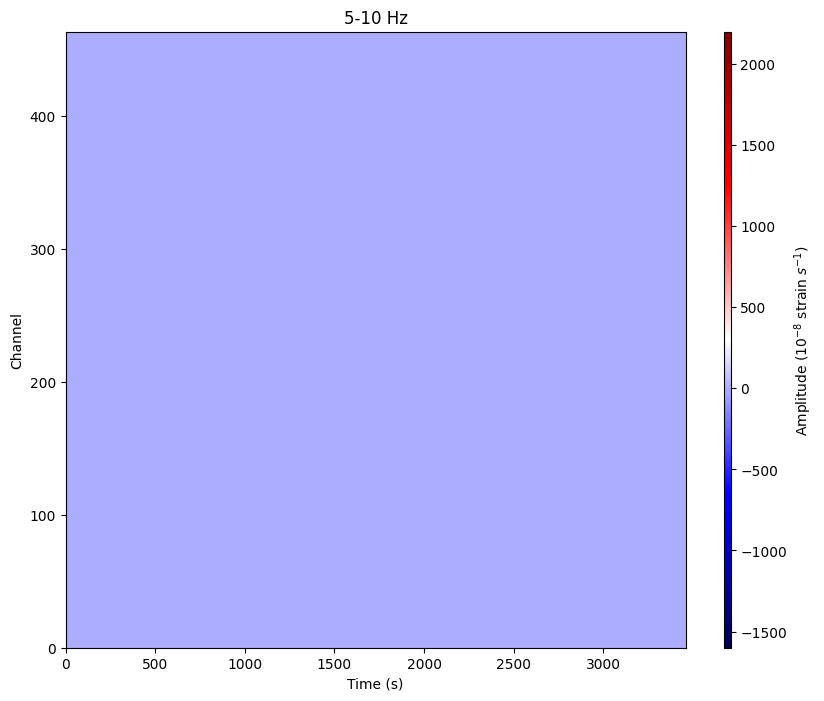

dx= 2.0  dt= 0.02   start=  0.0


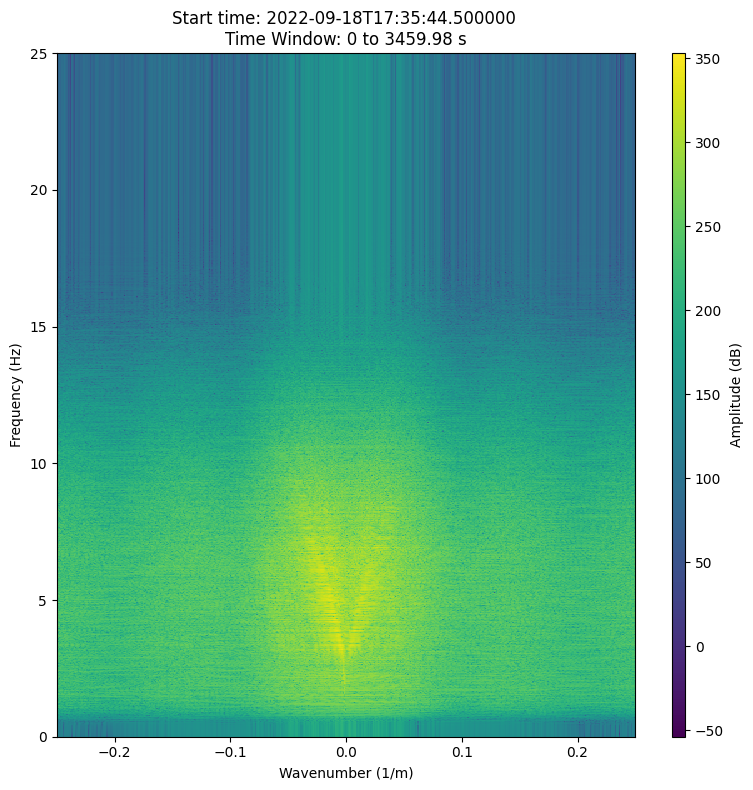

In [59]:
dt = ( ds['times'][1].item() - ds['times'][0].item() ) * 1e-9 # s
fs = 1/dt # Hz

time = np.arange(0,ds.dims['times']*dt,dt)
t1 = 0
t2 = 300
time_cut = np.arange(t1,t2,dt)

timestamp_ms = ds['times'][0].item() * 1e-6
timestamp_str = datetime.datetime.utcfromtimestamp(timestamp_ms / 1000).isoformat()
starttime = np.datetime64(timestamp_str)

lowcut = 1
highcut = 10
fs = 1/dt
apply_filter = True

if apply_filter:
	for i_channel in range(ds.dims['channels']):
		ds['strain_rates'][:,i_channel] = filter_bandpass(ds['strain_rates'][:,i_channel].values, lowcut, highcut, fs, order=2)


start_channel = 0
nb_channel = 463 - start_channel
das = np.flip(ds['strain_rates'][int(t1/dt):int(t2/dt),start_channel:start_channel+nb_channel].T,0) # the purpose of this weird line is to rearrange the 2D array for imshow so that the starting point of offset and time is in the bottom left
extent = [time[int(t1/dt)],time[int(t2/dt)],start_channel,start_channel+nb_channel]

plt.figure(figsize=(10,8))
a = plt.imshow(das, aspect='auto', vmin=np.min(das.data)/10, vmax=np.max(das.data)/10, extent=extent, cmap='seismic')
colorbar = plt.colorbar(a,orientation="vertical", pad=0.05, location='right', aspect=100)
colorbar.set_label(label='Amplitude ($10^{-8}$ strain $s^{-1}$)', rotation=90)
plt.xlabel('Time (s)')
plt.ylabel('Channel')
#plt.title(f'Start time: {starttime} \nTime Window: {str(t1)} to {str(t2)} s' ) 
plt.title('1-10 Hz')
plt.clim(-1600,2200)
plt.show()

# F-K computation    
dx = ds['offsets'][1].item() - ds['offsets'][0].item()
dt= ( ds['times'][1].item() - ds['times'][0].item() ) * 1e-9

print('dx=',dx,' dt=',dt,'  start= ',str(time_cut[0]))

f, k, fk = fk_analysis(das.T, dt, dx, dbscale=True, onesided=True)    

plt.figure(figsize=(8,8))                                                   
ax = plt.gca()                                                                          
fkmax = np.nanmax(fk.flatten())                                             
fkmin = np.nanmin(fk.flatten())                                       
im = ax.pcolor(k,f,fk,vmin = fkmin,vmax=fkmax,cmap=plt.cm.viridis)                                        
#ax.set_xlim(-0.5,0.5)     
#ax.set_ylim(0.05,0.5)      
ax.set_xlabel('Wavenumber (1/m)')                                              
ax.set_ylabel('Frequency (Hz)')                                             
ax.set_title(f'Start time: {starttime} \nTime Window: {str(t1)} to {str(t2)} s' ) 
colorbar = plt.colorbar(im, aspect=50)
colorbar.set_label(label='Amplitude (dB)', rotation=90)
plt.tight_layout()
plt.show()